#Building a classification model using XGBoost in Python


##Introduction

###Breakdown of XGBoost

XGBoost, or Extreme Gradient Boosting, is a high-performing, regularized form of gradient boosting. For this project, I'm going to assume that you have a basic understanding of tree-based models and the gradient boosting algorithm. Like gradient boosting, XGBoost trains tree models sequentially and learns and improves at each step based on the results of the last step. Gradient boosting does this by taking the derivative, or gradient, of the loss function. Using a set learning rate and step size, this gradient is used to update parameters until they converge to an optimal solution. 

XGBoost builds on this gradient algorithm by taking the second derivative of the loss function and by adding L1/L2 regularization to the model to improve performance. The model is represented mathematically as follows:


$$obj(\theta) = L(\theta) + Ω(\theta)$$ where $L$ represents the loss function and $\Omega$ represents the regularization term. 

XGBoost also takes advantage of parallel/distriubuted computing, which allows for incredibly fast performance when training on large datasets.

### Running XGBoost in Python

XGBoost models can be easily implemented using the `xgboost` library, with installation instructions found at (https://xgboost.readthedocs.io/en/stable/install.html).

Like all machine learning techniques, some preprocessing steps are needed to make sure the model runs well.

In order to practice, we will be taking a look at a subset of data that was compiled from the Bureau of Trans- portation statistics and National Centers for Environmental Information (NOAA) that contains detailed airline, weather, airport and employment information. The goal is to predict whether or not a flight will be delayed by more than 15 minutes (DEP DEL15).

#### Import Data

I will be coding this up in google colab in order to take advantage of their free GPU's for training the model later. Lets start by importing packages, and importing data. In addition to the xgboost library, we will be using os, pandas, and numpy to assist in computing; sklearn for data preprocessing and model evaluation; and hyperopt for hyperparameter tuning.

In [47]:
# required packages
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval

In [2]:
# setting filepath to read data
os.chdir('/content/drive/MyDrive/project2')

In [3]:
# reading data
df = pd.read_csv('train_data.csv.zip')

#### Explore data

In [4]:
df.head()

,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,PLANE_AGE,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
0,3,4,0,2200-2259,2,8,21,90,Comair Inc.,11965,...,5,Ronald Reagan Washington National,38.852,-77.037,Memphis International,0.00,0.0,0.0,64.0,8.50
1,2,1,0,2000-2059,2,6,44,180,Delta Air Lines Inc.,10714,...,6,Minneapolis-St Paul International,44.886,-93.218,Stapleton International,0.01,0.0,0.0,81.0,6.93
2,9,1,1,1800-1859,3,8,92,50,American Eagle Airlines Inc.,28583,...,21,Chicago O'Hare International,41.978,-87.906,Rochester Municipal,0.00,0.0,0.0,74.0,7.83
3,5,3,0,1600-1659,3,3,72,129,Delta Air Lines Inc.,34238,...,11,Atlanta Municipal,33.641,-84.427,Jacksonville International,0.00,0.0,0.0,84.0,6.71
4,6,7,0,1900-1959,2,1,56,173,United Air Lines Inc.,28904,...,6,Chicago O'Hare International,41.978,-87.906,NONE,0.38,0.0,0.0,81.0,10.29


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1266241 entries, 0 to 1266240
Data columns (total 26 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   MONTH                          1266241 non-null  int64  
 1   DAY_OF_WEEK                    1266241 non-null  int64  
 2   DEP_DEL15                      1266241 non-null  int64  
 3   DEP_TIME_BLK                   1266241 non-null  object 
 4   DISTANCE_GROUP                 1266241 non-null  int64  
 5   SEGMENT_NUMBER                 1266241 non-null  int64  
 6   CONCURRENT_FLIGHTS             1266241 non-null  int64  
 7   NUMBER_OF_SEATS                1266241 non-null  int64  
 8   CARRIER_NAME                   1266241 non-null  object 
 9   AIRPORT_FLIGHTS_MONTH          1266241 non-null  int64  
 10  AIRLINE_FLIGHTS_MONTH          1266241 non-null  int64  
 11  AIRLINE_AIRPORT_FLIGHTS_MONTH  1266241 non-null  int64  
 12  AVG_MONTHLY_PA

#### Data preprocessing

After taking a quick look at our data, it's now time to do some preprocessing. I'm going to define a function with all of the preprocessing steps and then go over some items specifically.

In [6]:
# Preprocessing function definitions and train test split
def data_processing(data):
  # target
  y = data['DEP_DEL15']
  # features
  X = data.drop(['DEP_DEL15','PREVIOUS_AIRPORT'], axis=1)
  # setting some discrete numeric features as categorical
  X[['MONTH', 'DAY_OF_WEEK', 'DISTANCE_GROUP']] = X[['MONTH', 'DAY_OF_WEEK', 'DISTANCE_GROUP']].astype(object)
  # defining numeric features and processor
  numeric = X.select_dtypes(exclude='object').columns
  numeric_processor = Pipeline([
    ('scaler', StandardScaler())
  ])
  # defining categorical features and processor
  cat = X.select_dtypes(include='object').columns
  categorical_processor = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
  ])
  # defining complete preprocessor
  preprocessor = ColumnTransformer([
    ('num', numeric_processor, numeric),
    ('cat', categorical_processor, cat)
  ])
  # making train test split and fitting preprocessor
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25, random_state=909)
  X_train = preprocessor.fit_transform(X_train)
  X_test = preprocessor.transform(X_test)
  feature_names = preprocessor.get_feature_names_out(X.columns)
  

  return X_train, X_test, y_train, y_test, feature_names

X_train, X_test, y_train, y_test, feature_names = data_processing(df)


#### Defining target and feature variables

I'm going to go over a few things just do we make sure that we all understand what's going on. First, we want to split our target and feature variables up:
```
y = data['DEP_DEL15']
X = data.drop(['DEP_DEL15','PREVIOUS_AIRPORT'], axis=1)
X[['MONTH', 'DAY_OF_WEEK', 'DISTANCE_GROUP']] = X[['MONTH', 'DAY_OF_WEEK', 'DISTANCE_GROUP']].astype(object)
```
Notice that in addition to dropping our target from the features, I've also dropped the PREVIOUS_AIRPORT field as well. The LATITUDE and LONGITUDE variables provide the location of the previous airport, so I felt that this would be redundant information. There were also a few discrete features that are better represented as categorical data, so that change was made as well.

#### Creating preprocessing pipelines

Now that the target and features are in their own space. It's time to define some preprocessing pipelines. The data that we're working with has both categorical and numeric features, so it's easiest to create two seperate processors for both types, and then combine with a column transformer as follows:
```
numeric = X.select_dtypes(exclude='object').columns
numeric_processor = Pipeline([
  ('scaler', StandardScaler())
])

cat = X.select_dtypes(include='object').columns
categorical_processor = Pipeline([
  ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
  ('num', numeric_processor, numeric),
  ('cat', categorical_processor, cat)
])
```
In order for the column transformer to work, the indices of the features need to be passed, so those need to be defined as they are above in the numeric and cat variables. For the numeric features, the only thing that we will do is standardize the variables. The categorical features will be encoded using one hot encoding. These two processors can be combined into a single processor using the column transformer.

#### Splitting data for training and testing
The next step is to randomly split up the data for training and then testing the model. It's easiest to do this with the `train_test_split` function from the `sklearn` library: 
```
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25 random_state=909)
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out(X.columns)
```
After splitting up the data, push it through the preprocessor in order to apply those transformations and put the data in a final state for modeling. It's also useful to save the feature names in case you need them later.

At the end of the function, we can return all of the things that we need:
```
return X_train, X_test, y_train, y_test, feature_names
```
Now we can just call the function and input the data to get everything ready to go:
```
X_train, X_test, y_train, y_test, feature_names = data_processing(df)
```

### Training the model
#### Hyperparameter tuning
With all the data cleaned and processed, it's time to begin training our model. The most effective way to train a model is by tuning hyperparameters through the use of cross validation. The `hyperopt` library uses a form of Bayesian optimization for parameter tuning that allows you to get the best parameters for a given model. Hyperparameter tuning with hyperopt has three features: space, objective, and fmin. Let's first look at the space in the code below:

In [7]:
space = {
    'learning_rate' : hp.choice('learning_rate', [0.01,0.1]),
    'min_child_weight' : hp.choice('min_child_weight', np.arange(1,5,1, dtype=int)),
    'max_depth' : hp.choice('max_depth', np.arange(3,12,3, dtype=int)),
    'gamma': hp.choice('gamma', [i/10.0 for i in range(0,5)]),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.5, 1.0, 0.1)),
    'n_estimators': hp.choice('n_estimators', [100,150]),
    'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
    'reg_lambda' : hp.uniform('reg_lambda', 0,1)
    }

As you've probably guessed, the space holds information concerning the hyperparameters that will be tuned in the model. I'm not going to go into detail on the different hyperparameters, so be sure to check out the xgboost documentation to learn more.

The next feature is the objective function, which is defined below:

In [8]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=909)
def objective(space):
  xgb_clf = XGBClassifier(**space, seed=909, objective='binary:logistic', tree_method='gpu_hist', scale_pos_weight=1/.187)
  score = cross_val_score(estimator= xgb_clf,
                          X=X_train,
                          y=y_train,
                          cv=kfold,
                          scoring='f1',
                          n_jobs=-1).mean()

  loss = - score

  return {'loss' : loss, 'params' : space, 'status' : STATUS_OK}

The objective function holds the definition for the model, and the evaluation metric. Using `StratifiedKFoldValidation`, the best objective function will be used to optimize our metric, in this case the F1 score. 

There are a couple items in the objective function that I want to point out. Within the definition of the XGBClassifier, I have two additional hyperparameters set. The first is the tree_method which is set for 'gpu_hist'. This allows for the use of a GPU for training and can help train the model faster. The second is the scale_pos_weight, which can be used in the case of imbalanced data. If we take a look at the target variable, about 80% of the target variables fall into the non-delayed class. This is a heavy imbalance and requires some adjustments to the model. A good rule of thumb is to take 1 / the ratio of your less reprented class. In this case, we're going to set that weight as 1/.187 to help with the imbalance.



<Axes: xlabel='DEP_DEL15', ylabel='Probability'>

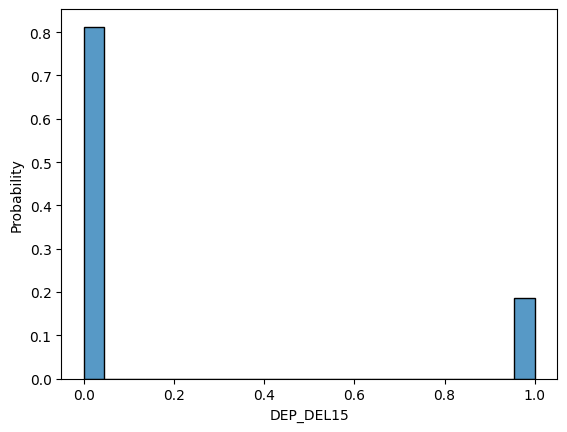

In [22]:
sns.histplot(data=df, x='DEP_DEL15', stat='probability')


The third feature is the `fmin` function which takes the objective function and the space and begins that cross-validation process for picking those hyperparameters. Let's get that started now:

In [23]:
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 20, return_argmin=False)


100%|██████████| 20/20 [14:48<00:00, 44.45s/trial, best loss: -0.42560369413745747]


Now take a look at the values for those hyperparameters

In [24]:
best

{'colsample_bytree': 0.6,
 'gamma': 0.2,
 'learning_rate': 0.1,
 'max_depth': 9,
 'min_child_weight': 1,
 'n_estimators': 150,
 'reg_alpha': 65.0,
 'reg_lambda': 0.1452277681223374}

#### Fitting the model
Now that the hyperparemeters are tuned, we can pass the best dictionary into the XGBClassifier to fit the model.

In [25]:
model = XGBClassifier(**best,objective='binary:logistic', tree_method='gpu_hist', scale_pos_weight=1/.187)
model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### Evaluate the model
Now that the model has been fit, let's look at how the model performs. I am going to define a function that takes the model and the data as an input and returns accuracy, ROC_AUC, and F1:

In [26]:
def evaluate(model,x,y):
  preds = model.predict(x)
  proba = model.predict_proba(x)[:,1]
  accuracy = round(accuracy_score(y, preds),3)
  roc_auc = round(roc_auc_score(y, proba),3)
  f1 = round(f1_score(y,preds),3)

  print(f'Accuracy: {accuracy}')
  print(f'ROC AUC: {roc_auc}')
  print(f'F1: {f1}')

In [27]:
evaluate(model, X_test, y_test)

Accuracy: 0.626
ROC AUC: 0.74
F1: 0.425


In [57]:
evaluate(model, X_train, y_train)

Accuracy: 0.632
ROC AUC: 0.756
F1: 0.436


### Conclusion
Unfortunately, this particular dataset is a bit more difficult to accuractely model with the significant imbalance in the data. We do the best that we can with the data that is provided. In the words of famous statistician George Box, "all models are wrong, but some are useful". I hope that this had increased your understanding of XGBoost and it's potential for training highly generalized models and large datasets in a quick amount of time.